In [1]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
def loaddata():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)
    x_train = (x_train[(y_train == 1) | (y_train == 7),]- 127.5) / 127.5
    y_train = y_train[(y_train == 1) | (y_train == 7)]
    y_train = np.where(y_train == 1, 0, 1).reshape((-1,1))

    x_test = (x_test[(y_test == 1) | (y_test == 7),]- 127.5) / 127.5
    y_test = y_test[(y_test == 1) | (y_test == 7)]
    y_test = np.where(y_test == 1, 0, 1).reshape((-1,1))

    np.random.seed(0)
    rand_idx = np.random.choice(np.arange(x_train.shape[0]), size = 20, replace = False)
    x_train = x_train[rand_idx]
    y_train = y_train[rand_idx]

    return x_train, y_train, x_test, y_test


In [3]:
x_train, y_train, x_test, y_test = loaddata()

In [4]:
def trainsvc(xtrain, ytrain):
    x = np.squeeze(xtrain)
    xt = x.reshape((x.shape[0],-1))
    svc = SVC(kernel='linear', gamma=0.001).fit(xt, ytrain.ravel())
    return svc

In [5]:
def loadgenerator(generatorpath):
    generator = load_model(generatorpath)
    generator.trainable = False
    return generator

In [6]:
def loadoracle(oraclepath):
    oracle = load_model(oraclepath)
    oracle.trainable = False
    return oracle

In [7]:
generator = loadgenerator('./cifar10/generator_model_100.h5')
oracle = loadoracle('./oracles/cifar10horseautomobile.h5')

In [10]:
def generatesamples(n_iter, x_train, y_train, x_test, y_test):
    
    x_test = np.squeeze(x_test)
    x_test = x_test.reshape((x_test.shape[0],-1))

    y_test = y_test.ravel()
    learner_acc = []

    for i in range(n_iter):
        print(f'Round {i+1}')
        # train an svc using the training set
        print(f'Updating SVC')

        svc = trainsvc(x_train, y_train)
        svc_preds = svc.predict(x_test)
        acc = accuracy_score(y_test, svc_preds)
        print(f'Learner Accuracy: {acc}')
        learner_acc.append(acc)

        w = svc.coef_
        b = svc.intercept_

        w = tf.cast(tf.reshape(tf.Variable(w), [-1]), tf.float32)
        b = tf.cast(tf.Variable(b), tf.float32)

        print(f'Generating latents')
        cnt = 0
        zs = []

        # perform gradient descent on SVC with random start and get 10 minimum points
        while cnt < 10:

            z = np.random.randn(100).reshape((1,-1))
            z = tf.Variable(z)

            for _ in range(100):
                with tf.GradientTape() as tape:
                    # Forward pass
                    tape.watch(z)
                    f = generator(z)
                    f = tf.reshape(f, [-1])
                    dot = tf.tensordot(f, w, 1) + b    
                    loss = (dot**2)

                # Calculate gradients with respect to every trainable variable
                grad = tape.gradient(loss, z)
                opt = tf.keras.optimizers.SGD()
                opt.apply_gradients(zip([grad], [z]))

            zs.append(z.numpy())
            cnt += 1

        print(f'Generating fake images using GAN')
        # take the 10 minimum points and generate 10 fake images
        zt = np.vstack(zs)
        gen = generator.predict(zt)

        # use oracle to predict the label of the generated pictures
        # gen_3c = np.repeat(gen, 3, axis = 3)
        # gen_3c_32 = (tf.image.resize(gen_3c, [32,32]) + 1)/2
        # oracle_labels = np.squeeze(oracle.predict(gen_3c_32))

        oracle_labels = np.squeeze(oracle.predict(gen))

        print(f'Updating training set\n')
        # pick only the good generated images subject to threshold and add to training set
        threshold = 1e-7
        gen_good = gen[(oracle_labels < threshold) | (oracle_labels > 1-threshold)]
        gen_good_labels = oracle_labels[(oracle_labels < threshold) | (oracle_labels > 1-threshold)]
        gen_good_labels = np.round(gen_good_labels).astype(int)
        gen_good_labels = np.expand_dims(gen_good_labels, axis = -1)

        # append the good data to the labeled set
        x_train = np.concatenate((x_train, gen_good), axis = 0)
        y_train = np.concatenate((y_train, gen_good_labels), axis = 0)
    
    return x_train, y_train, learner_acc

Round 1
Updating SVC
Learner Accuracy: 0.725
Generating latents
Generating fake images using GAN
Updating training set

Round 2
Updating SVC
Learner Accuracy: 0.705
Generating latents
Generating fake images using GAN
Updating training set

Round 3
Updating SVC
Learner Accuracy: 0.7065
Generating latents
Generating fake images using GAN
Updating training set

Round 4
Updating SVC
Learner Accuracy: 0.7065
Generating latents
Generating fake images using GAN
Updating training set

Round 5
Updating SVC
Learner Accuracy: 0.699
Generating latents
Generating fake images using GAN
Updating training set



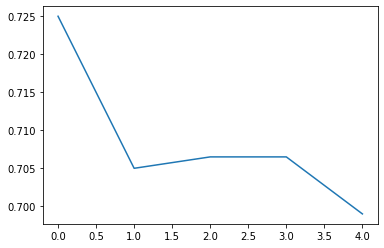

In [11]:
a, b, acc = generatesamples(5, x_train, y_train, x_test, y_test)
plt.plot(acc)

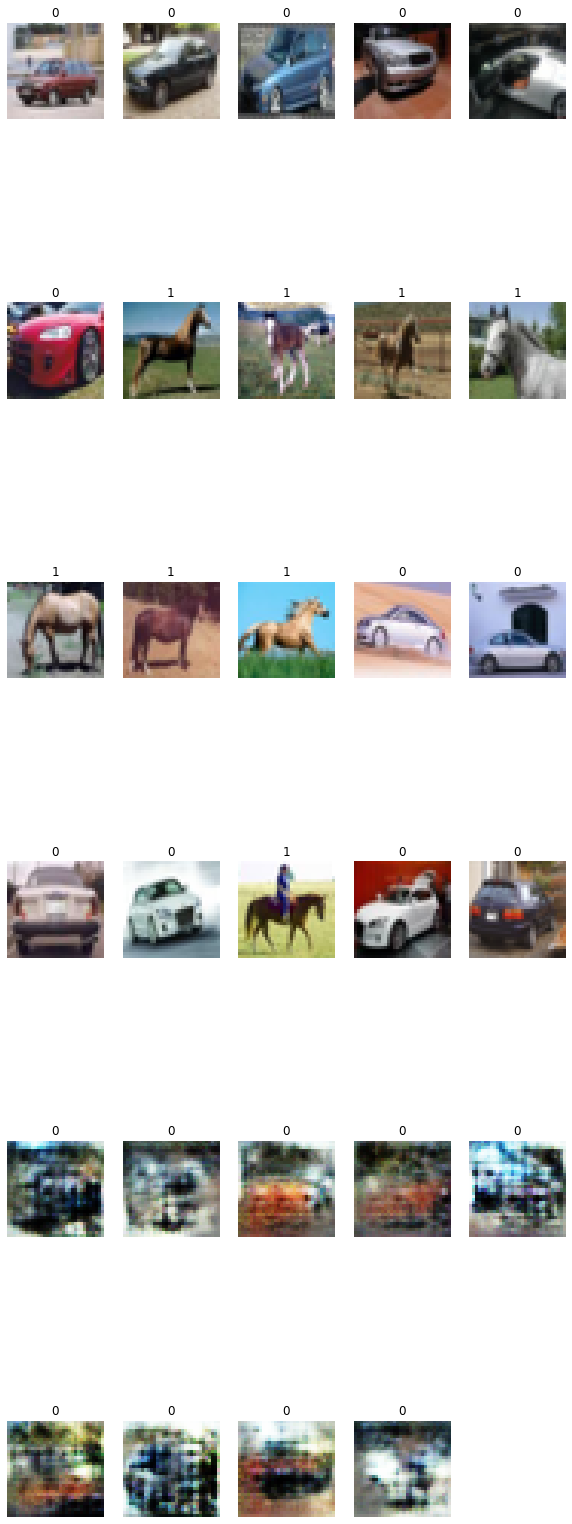

In [14]:
plt.figure(figsize=(10,30))
a = (a*127.5)+127.5
a = a.astype('uint8')
for i in range(a.shape[0]):
    plt.subplot(int(a.shape[0]/5)+1,5,i+1)
    plt.title(b[i][0])
    plt.axis('off')
    plt.imshow(np.squeeze(a[i]))
    
plt.show()

In [12]:
b.shape

(29, 1)